In [16]:
import numpy as np
import scipy.signal
from matplotlib.pyplot import *
import librosa
import os
import matplotlib.pyplot as plt
import librosa.display
from filter_function import *
from spectrogram import *
from wav_preprocessing import *
import matplotlib.image as mpimg
import glob
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D, UpSampling2D, Input,Dropout,Conv2DTranspose,Concatenate
from keras.layers import  Conv1D, MaxPooling1D, UpSampling1D,Concatenate, PReLU
from keras import optimizers
from error_measure import *

In [17]:
original_dataset_dir = "C:\\Users\\joaro\\OneDrive\\Documents\\deep_learning_jupiter\\free_spoken_digit_dataset\\recordings\\"

base_dir = "C:\\Users\\joaro\\OneDrive\\Documents\\deep_learning_jupiter\\free_spoken_digit_dataset\\super_resolution_re_im"
train_dir = os.path.join(base_dir, 'train\\')

test_dir = os.path.join(base_dir, 'test\\')
train_dir_filtré=os.path.join(base_dir, 'train_dir_filtré\\')
test_dir_filtré=os.path.join(base_dir, 'test_dir_filtré\\')

In [3]:
Xtest,max_test= dir_to_wav_array(test_dir)
Xtrain,max_train= dir_to_wav_array(train_dir)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\5_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\7_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\9_theo_16.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\9_theo_28.wav


In [18]:
fce=0.0680#sr=22050
ftype="butter"
ordre=2
b,a = creer_filter(fce,"highpass",ftype,ordre)
filter_path(train_dir,train_dir_filtré,b,a)
filter_path(test_dir,test_dir_filtré,b,a)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\


In [5]:
print(Xtest.shape)

(200, 8000, 1, 1)


In [6]:
Xtrain_fil,max_train_fil=dir_to_wav_array(train_dir_filtré)
Xtest_fil,max_test_fil=dir_to_wav_array(test_dir_filtré)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\5_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\7_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\9_theo_16.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\9_theo_28.wav
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test_dir_filtré\


In [7]:
#réseau audio net
input_img = Input(shape=(8000,1,1))

conv1= Conv2D(32, (7, 1), padding='same',strides=1)(input_img)
conv1 = PReLU(shared_axes=[1, 2], name='prelu1')(conv1)
max1= MaxPooling2D((2, 1), padding='same')(conv1)

conv3 = Conv2D(32, (7, 1), padding='same',strides=1)(max1)
conv3 = PReLU(shared_axes=[1, 2], name='prelu3')(conv3)              
encoded = MaxPooling2D((2, 1), padding='same')(conv3)
x = Conv2D(32, (7, 1), padding='same',strides=1)(encoded)
x = PReLU(shared_axes=[1, 2], name='prelu4')(x)
x = Conv2D(32, (7, 1), padding='same',strides=1)(x)
x = PReLU(shared_axes=[1, 2], name='prelu5')(x)
x = Conv2D(32, (7, 1), padding='same',strides=1)(x)
x = PReLU(shared_axes=[1, 2], name='prelu6')(x)

x = UpSampling2D((2, 1))(x)
# merge2=Concatenate(axis=-1)([x,conv3])
x = Conv2D(32, (7, 1), padding='same',strides=1)(x)
x = PReLU(shared_axes=[1, 2], name='prelu8')(x)
# x=Dropout(0.5)(x)
x = UpSampling2D((2, 1))(x)
# merge1=Concatenate(axis=-1)([x,conv1])
decoded = Conv2D(1, (7, 1), padding='same',strides=1)(x)
decoded = PReLU(shared_axes=[1, 2], name='prelu9')(decoded)
# decoded=Dropout(0.5)(decoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizers.Adam(lr=0.001), loss='mae')
#optimizer=optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False)
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8000, 1, 32)       256       
_________________________________________________________________
prelu1 (PReLU)               (None, 8000, 1, 32)       32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4000, 1, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4000, 1, 32)       7200      
_________________________________________________________________
prelu3 (PReLU)               (None, 4000, 1, 32)       32        
_________________________________________________________________
max_

In [89]:
G=1
history=autoencoder.fit(Xtrain_fil*G,Xtrain*G,epochs=40,
                batch_size=20,
                shuffle=True,
                validation_data=(Xtest_fil*G, Xtest*G))

Train on 1800 samples, validate on 200 samples
Epoch 1/40
1800/1800 [==============================] - 10s 5ms/step - loss: 0.0164 - val_loss: 0.0149
Epoch 2/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0162 - val_loss: 0.0149
Epoch 3/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0165 - val_loss: 0.0148
Epoch 4/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0159 - val_loss: 0.0145
Epoch 5/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0159 - val_loss: 0.0150
Epoch 6/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0159 - val_loss: 0.0150
Epoch 7/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0162 - val_loss: 0.0149
Epoch 8/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0161 - val_loss: 0.0146
Epoch 9/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0158 - val_loss: 0.0144
Epoch 10/40
1800/1800 [===========

In [90]:
# autoencoder.save("audio_network_low_250Hz_80epochs.h5")

In [91]:
# autoencoder=load_model("audio_network.h5")

In [92]:
decoded = autoencoder.predict(Xtest_fil)

In [93]:
p=15
sr=8000
#indice to display
xtest=np.reshape(Xtest[p],(8000))
audio_path_record="C:\\Users\\joaro\\OneDrive\\Documents\\deep_learning_jupiter\\free_spoken_digit_dataset\\"
audio_path_record_in=os.path.join(audio_path_record,"0_jackson_0_wav_test.wav")
soundfile.write(audio_path_record_in,xtest*max_test[p],sr)
ipd.Audio(audio_path_record_in)

In [94]:
print(Xtest[p]*max_test[p])

[[[0.00015959]]

 [[0.00010922]]

 [[0.00032732]]

 ...

 [[0.        ]]

 [[0.        ]]

 [[0.        ]]]


In [95]:
print(decoded[p])

[[[-1.3332958e-03]]

 [[-8.8319310e-04]]

 [[-5.3740368e-04]]

 ...

 [[ 1.0144099e-04]]

 [[ 2.0875351e-04]]

 [[-4.9634153e-05]]]


In [96]:
y=np.reshape(decoded[p],(8000))
bpost,apost=creer_filter(0.005,"highpass","butter",ordre=6)
y_fil=filtrage(bpost,apost,y)
audio_path_record_out=os.path.join(audio_path_record,"0_jackson_0_wav_reconstructed.wav")
soundfile.write(audio_path_record_out,y*max_test[p],sr)
ipd.Audio(audio_path_record_out)

In [97]:
xtest_fil=np.reshape(Xtest_fil[p],(8000))
audio_path_record_in_fil=os.path.join(audio_path_record,"0_jackson_0_filtered.wav")
soundfile.write(audio_path_record_in_fil,xtest_fil*max_test_fil[p],sr)
ipd.Audio(audio_path_record_in_fil)

In [98]:
import sklearn
error=sklearn.metrics.mean_squared_error(xtest,y)
print(error)

0.0012605975799519888


In [99]:
error_fil=sklearn.metrics.mean_squared_error(xtest,y_fil)
print(error_fil)

0.001260165984636795


(1025, 16)
(1025, 16)
(1025, 16)


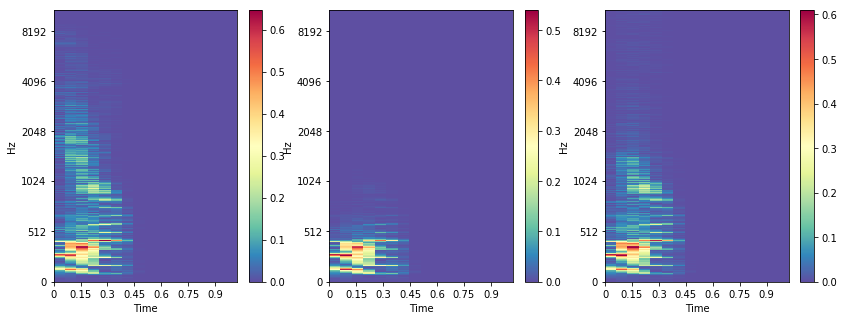

In [100]:
X=librosa.stft(xtest*max_test[p])
Xdec=librosa.stft(y*max_test[p])
Xfil=librosa.stft(xtest_fil*max_test_fil[p])
figure(figsize=(14, 5))
plt.subplot(1,3,1)
Xdb = np.log10(abs(X)+1)
print(Xdb.shape)
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='mel',cmap='Spectral_r')
colorbar()
plt.subplot(1,3,2)
Xfildb = np.log10(abs(Xfil)+1)
print(Xfildb.shape)
librosa.display.specshow(Xfildb, sr=sr, x_axis='time', y_axis='mel',cmap='Spectral_r')
colorbar()
plt.subplot(1,3,3)
Xdecdb = np.log10(abs(Xdec)+1)
print(Xdecdb.shape)
librosa.display.specshow(Xdecdb, sr=sr, x_axis='time', y_axis='mel',cmap='Spectral_r')
colorbar()

In [101]:
error_spec=sklearn.metrics.mean_squared_error(Xdb,Xdecdb)
print(error_spec)

0.00015873677


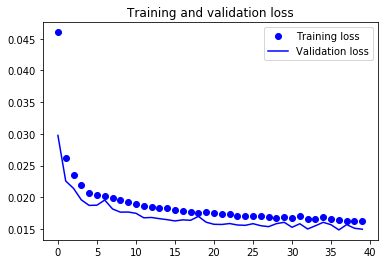

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
# mel spectro reconstruction
Xtest_mel,Phase_test=dir_to_log_mel(test_dir)
Xtrain_mel,Phase_train=dir_to_log_mel(train_dir)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\5_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\7_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\9_theo_16.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\9_theo_28.wav


In [20]:
Xtrain_fil_mel,Phase_train_fil=dir_to_log_mel(train_dir_filtré)
Xtest_fil_mel,Phase_test_fil=dir_to_log_mel(test_dir_filtré)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\5_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\7_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\9_theo_16.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\9_theo_28.wav
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test_dir_filtré\


In [21]:
input_mel = Input(shape=(1024, 16,1))

conv1= Conv2D(32, (3, 3), activation='relu', padding='same')(input_mel)
max1= MaxPooling2D((2, 1), padding='same')(conv1)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(max1)
encoded = MaxPooling2D((2, 1), padding='same')(conv2)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 1))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 1))(x)



decoded_mel = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
autoencoder_mel = Model(input_mel, decoded_mel)
autoencoder_mel.compile(optimizer=optimizers.Adam(lr=0.001), loss='mae')
#optimizer=optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False)
autoencoder_mel.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1024, 16, 1)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1024, 16, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 512, 16, 32)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 512, 16, 32)       9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 256, 16, 32)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 256, 16, 32)       9248      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 256, 16, 32)       9248      
__________

In [22]:
history=autoencoder_mel.fit(Xtrain_fil_mel,Xtrain_mel,epochs=40,
                batch_size=20,
                shuffle=True,
                validation_data=(Xtest_fil_mel, Xtest_mel))

Train on 1800 samples, validate on 200 samples
Epoch 1/40
1800/1800 [==============================] - 13s 7ms/step - loss: 0.0273 - val_loss: 0.0243
Epoch 2/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0244 - val_loss: 0.0218
Epoch 3/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0248 - val_loss: 0.0238
Epoch 4/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0238 - val_loss: 0.0228
Epoch 5/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0223 - val_loss: 0.0206
Epoch 6/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0220 - val_loss: 0.0229
Epoch 7/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0218 - val_loss: 0.0196
Epoch 8/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0210 - val_loss: 0.0192
Epoch 9/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0200 - val_loss: 0.0187
Epoch 10/40
1800/1800 [===

In [23]:
# autoencoder_mel.save("mel_spec_network_low_250Hz_80epochs.h5")

In [24]:
# autoencoder_mel=load_model("mel_spec_network.h5")

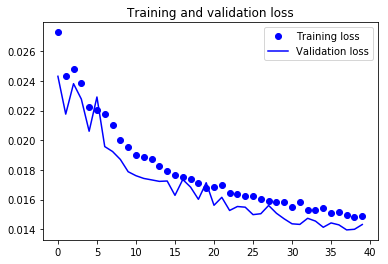

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [102]:
decoded_mel = autoencoder_mel.predict(Xtest_fil_mel)

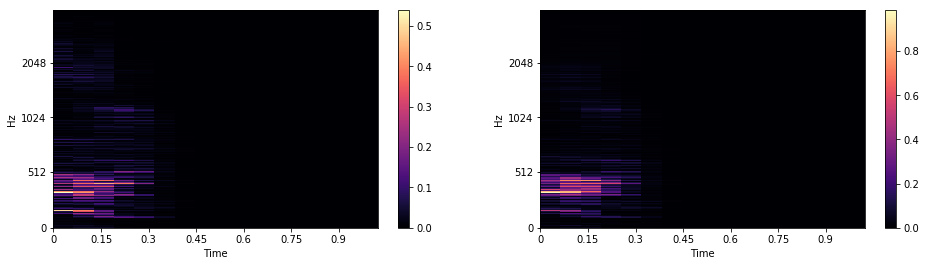

In [177]:
p3=16
Spec_dec=np.reshape(decoded_mel[p3],(decoded_mel.shape[1],decoded_mel.shape[2]))
Spec=np.reshape(Xtest_mel[p3],(Xtest_mel.shape[1],Xtest_mel.shape[2]))
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
librosa.display.specshow(Spec, sr=8000, x_axis='time', y_axis='mel',fmax=4000)
colorbar()
plt.subplot(1,2,2)
librosa.display.specshow(Spec_dec, sr=8000, x_axis='time', y_axis='mel',fmax=4000)
colorbar()

In [152]:
error_spec=sklearn.metrics.mean_squared_error(Spec,Spec_dec)
print(error_spec)

0.0008965459591307452


In [153]:
Lin_dec=mel_to_linspec(decoded_mel,sr=8000,n_mels=1024,n_fft=2048)
mix_audio=merge_specphase_to_audio(Lin_dec,decoded)

In [154]:
print(mse_audio(Xtest,Xtest_fil))

2.9144589336201402e-05


In [155]:
print(mse_audio(Xtest,decoded))

7.147538564179284e-06


In [156]:
print(mse_audio(Xtest,mix_audio))

1.5482311695926714e-05


In [157]:

xtest3=np.reshape(Xtest[p3],(8000))
soundfile.write(audio_path_record_in,xtest3*max_test[p3],sr)
ipd.Audio(audio_path_record_in)

In [158]:
xtest3_fil=np.reshape(Xtest_fil[p3],(8000))
soundfile.write(audio_path_record_in_fil,xtest3_fil*max_test_fil[p3],sr)
ipd.Audio(audio_path_record_in_fil)

In [159]:

audio_path_record_audio_mix3=os.path.join(audio_path_record,"3_mix.wav")
soundfile.write(audio_path_record_audio_mix3,mix_audio[p3],sr)
ipd.Audio(audio_path_record_audio_mix3)

In [160]:
y3=np.reshape(decoded[p3],(8000))
audio_path_record_out3=os.path.join(audio_path_record,"3_reconstructed.wav")
soundfile.write(audio_path_record_out3,y3*max_test[p3],sr)
ipd.Audio(audio_path_record_out3)

In [161]:
from scipy.stats import pearsonr
print(pearsonr(xtest3,y3)[0])

0.9731038461131436


In [162]:
print(pearsonr(xtest3,mix_audio[p3])[0])

0.8732845488249771


In [163]:
print(np.linalg.norm(xtest3))

15.978686570324717


In [164]:
print(np.linalg.norm(y3))

11.950835


In [165]:
print(np.linalg.norm(mix_audio[p3]))

0.9721342711074235


In [166]:
error3mix=sklearn.metrics.mean_squared_error(xtest3*1/np.linalg.norm(xtest3),mix_audio[p3]*1/np.linalg.norm(mix_audio[p3]))
print(error3mix)

3.167889633197626e-05


In [167]:
error3=sklearn.metrics.mean_squared_error(xtest3*1/np.linalg.norm(xtest3),y3*1/np.linalg.norm(y3))
print(error3)

6.724112095948076e-06


In [168]:
print(np.correlate(xtest3*1/np.linalg.norm(xtest3),mix_audio[p3]*1/np.linalg.norm(mix_audio[p3])))

[0.87328441]


In [169]:
print(np.correlate(xtest3*1/np.linalg.norm(xtest3),y3*1/np.linalg.norm(y3)))

[0.973104]


Text(0.5, 1.0, 'signal après mixage mel audio')

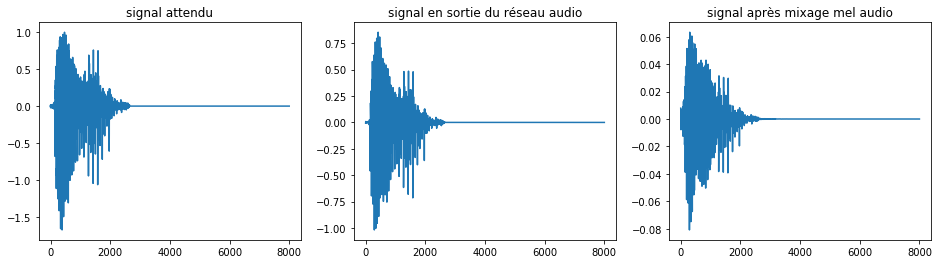

In [170]:
plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
plt.plot(xtest3)
title("signal attendu")
plt.subplot(1,3,2)
plt.plot(y3)
title("signal en sortie du réseau audio")
plt.subplot(1,3,3)
plt.plot(mix_audio[p3])
title("signal après mixage mel audio")

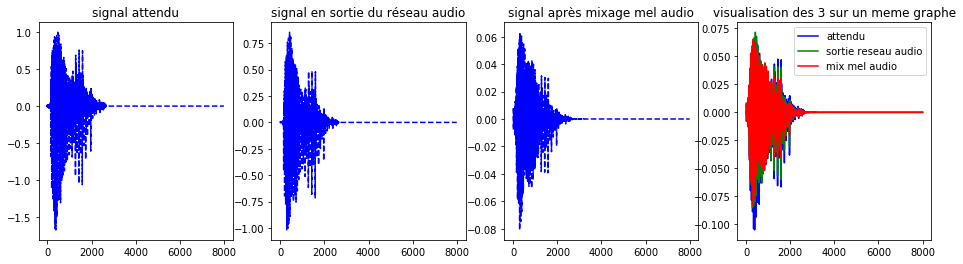

In [171]:
lim_sup=7999
lim_min=0

plt.figure(figsize=(16, 4))
plt.subplot(1,4,1)
plt.plot(xtest3[lim_min:lim_sup],"b--")
title("signal attendu")
plt.subplot(1,4,2)
plt.plot(y3[lim_min:lim_sup],"b--")

title("signal en sortie du réseau audio")
plt.subplot(1,4,3)
plt.plot(mix_audio[p3][lim_min:lim_sup],"b--")
title("signal après mixage mel audio")
plt.subplot(1,4,4)
plt.plot(xtest3[lim_min:lim_sup]*1/np.linalg.norm(xtest3),"b",label="attendu")
plt.plot(y3[lim_min:lim_sup]*1/np.linalg.norm(y3),"g",label="sortie reseau audio")
plt.plot(mix_audio[p3][lim_min:lim_sup]*1/np.linalg.norm(mix_audio[p3]),"r",label="mix mel audio")
title("visualisation des 3 sur un meme graphe")
plt.legend()

In [172]:
print(mse_melSpectro(Xtest_mel,Xtest_fil_mel))

1.364742587516125e-05


In [173]:
Spec_decoded=audioarray_to_melspectro(decoded)
print(mse_melSpectro(Xtest_mel,Spec_decoded))

8.740260362599786e-06


In [174]:
print(mse_melSpectro(Xtest_mel,decoded_mel))

5.466651814210304e-06


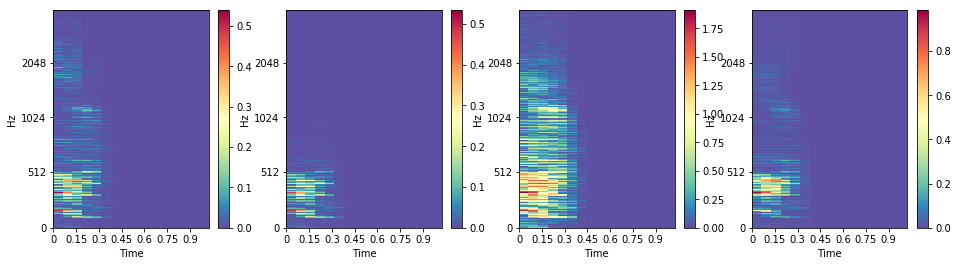

In [178]:

plt.figure(figsize=(16, 4))
plt.subplot(1,4,1)
librosa.display.specshow(np.reshape(Xtest_mel[p3],(1024,16)), sr=8000, x_axis='time', y_axis='mel',fmax=4000,cmap='Spectral_r')
colorbar()
plt.subplot(1,4,2)
librosa.display.specshow(np.reshape(Xtest_fil_mel[p3],(1024,16)), sr=8000, x_axis='time', y_axis='mel',fmax=4000,cmap='Spectral_r')
colorbar()
plt.subplot(1,4,3)
librosa.display.specshow(np.reshape(Spec_decoded[p3],(1024,16)), sr=8000, x_axis='time', y_axis='mel',fmax=4000,cmap='Spectral_r')
colorbar()
plt.subplot(1,4,4)
librosa.display.specshow(np.reshape(decoded_mel[p3],(1024,16)), sr=8000, x_axis='time', y_axis='mel',fmax=4000,cmap='Spectral_r')
colorbar()

In [128]:
Lin_test_mel=mel_to_linspec(Xtest_mel,sr=8000,n_mels=1024,n_fft=2048)

print(mse_melSpectro(Lin_test_mel,Lin_dec))

6.5881091380523276e-06


In [129]:
Lin_audio=mel_to_linspec(Spec_decoded,sr=8000,n_mels=1024,n_fft=2048)
print(mse_melSpectro(Lin_test_mel,Lin_audio))

1.1482385906653705e-06


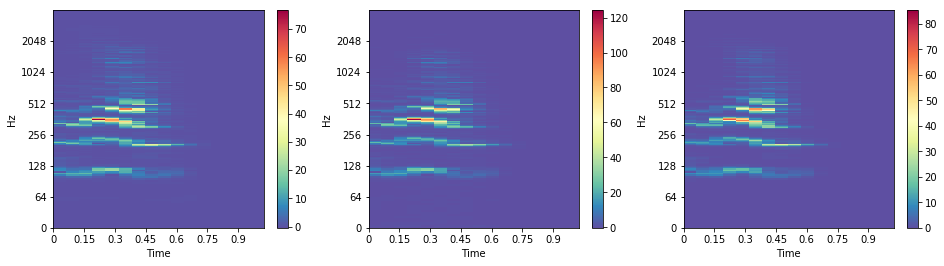

In [130]:
plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
librosa.display.specshow(Lin_test_mel[p3], sr=8000, x_axis='time', y_axis='log',fmax=4000,cmap='Spectral_r')
colorbar()
plt.subplot(1,3,2)
librosa.display.specshow(Lin_audio[p3], sr=8000, x_axis='time', y_axis='log',fmax=4000,cmap='Spectral_r')
colorbar()
plt.subplot(1,3,3)
librosa.display.specshow(Lin_dec[p3], sr=8000, x_axis='time', y_axis='log',fmax=4000,cmap='Spectral_r')
colorbar()